## 1. Download Kaggle data

In [ ]:
install        = False # to run the notebook without saving data in a drive 
ines           = 0
project_folder = 'Projet_NLP'
alexandre      = 1

import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import numpy.random as random
import urllib
import bs4
import collections
from urllib import request
import os
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from palettable.colorbrewer.qualitative import Pastel1_7

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# récupère les data sur un drive
if (ines==1) : 
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import os 
  os.chdir("/content/drive/MyDrive/" + project_folder)

if (alexandre==1) : 
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import os 
  os.chdir("/content/drive/MyDrive/" + project_folder)

Mounted at /content/drive


In [ ]:
# récupère et télécharge les data sur kaggle 
if (install == True) :
  ! pip install -q kaggle 
  # installation du package kaggle 

  ! mkdir ~/.kaggle/
  # création d'un dossier kaggle 

  #from google.colab import drive
  #drive.mount('/content/drive', force_remount=True)
  # connexion du drive pour accéder au fichier (sinon il faut le remettre à chaque fois)
  # le code ne fonctionnait pas pour moi jusqu'à ce que j'enlève ces deux lignes (ce pourquoi j'ai ajouté # pour les ignorer)

  ! cp '/content/drive/MyDrive/Projet_NLP/kaggle.json' ~/.kaggle/
  # copie kaggle.json dans le dossier kaggle

  ! chmod 600 ~/.kaggle/kaggle.json
  # donne les droits à kaggle.json

  ! kaggle datasets list 
  # vérifie que tout fonctionnne et qu'on accède au db kaggle 

  ! kaggle datasets download -d aashita/nyt-comments
  # télécharge les données kaggles 
  # NB il faut ensuite les copier dans un drive  

  ! unzip /content/drive/MyDrive/Projet_NLP/nyt-comments.zip -d nyt_data
  # unzippe vers un dossier nyt_data (qu'il vaut mieux ensuite copier sur le drive pour ne pas tout recommencer)  

## 2. Prepare data

We will try to predict the category of each article ("National", "Foreign", "Sport", "Culture"....) thanks to the compilation of its comments.

We will try several methods :
- For most of our methods, we will use comments to articles written from January 2017 to February 2017. 
- For our method based on neural networks, we will use a larger dataset (comments to articles written from January 2017 to May 2017) because the training set would be too small otherwise and the neural network would under-perform.

In [ ]:
# open databases
c1 = pd.read_csv('nyt_data/CommentsJan2017.csv')
c2 = pd.read_csv('nyt_data/CommentsFeb2017.csv')
c3 = pd.read_csv('nyt_data/CommentsMarch2017.csv')
c4 = pd.read_csv('nyt_data/CommentsApril2017.csv')
c5 = pd.read_csv('nyt_data/CommentsMay2017.csv')

# merge databases
comments = pd.concat([c1, c2])
comments_NN = pd.concat([c1, c2, c3, c4, c5])

# have a look at one of the dataframes
comments.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,15,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial
0,1483455908,58691a5795d0e039260788b9,1324,For all you Americans out there --- still rejo...,20969730.0,20969730.0,<br/>,comment,1483426105,1.0,0,0,National,0.0,NaN,20969730,https://graphics8.nytimes.com/images/apps/time...,1,5,NaN,0,NaN,Politics,0,approved,1,0,1483455908,N. Smith,64679318.0,New York City,NaN,NaN,News
1,1483455656,58691a5795d0e039260788b9,1324,Obamas policies may prove to be the least of t...,20969325.0,20969325.0,<br/>,comment,1483417407,1.0,0,0,National,0.0,NaN,20969325,https://graphics8.nytimes.com/images/apps/time...,1,3,NaN,0,NaN,Politics,0,approved,1,0,1483455656,Kilocharlie,69254188.0,Phoenix,NaN,NaN,News
2,1483455655,58691a5795d0e039260788b9,1324,Democrats are comprised of malcontents who gen...,20969855.0,20969855.0,<br/>,comment,1483431433,1.0,0,0,National,0.0,NaN,20969855,https://graphics8.nytimes.com/images/apps/time...,1,3,NaN,0,NaN,Politics,0,approved,1,0,1483455655,Frank Fryer,76788711.0,Florida,NaN,NaN,News
3,1483455653,58691a5795d0e039260788b9,1324,The picture in this article is the face of con...,20969407.0,20969407.0,<br/>,comment,1483418853,1.0,0,0,National,0.0,NaN,20969407,https://graphics8.nytimes.com/images/apps/time...,1,3,NaN,0,NaN,Politics,0,approved,1,0,1483455653,James Young,72718862.0,Seattle,NaN,NaN,News
4,1483455216,58691a5795d0e039260788b9,1324,Elections have consequences.,20969274.0,20969274.0,NaN,comment,1483416766,1.0,0,0,National,0.0,NaN,20969274,https://graphics8.nytimes.com/images/apps/time...,1,3,NaN,0,NaN,Politics,0,approved,1,0,1483455216,M.,7529267.0,Seattle,NaN,NaN,News


In [ ]:
# drop duplicated comments (if necessary) and reset index
comments.drop_duplicates(subset='commentID', inplace=True)
comments.reset_index(drop=True, inplace=True)
comments_NN.drop_duplicates(subset='commentID', inplace=True)
comments_NN.reset_index(drop=True, inplace=True)

In [ ]:
# keep only relevant columns
comments = comments[['articleID', 'commentBody', 'newDesk']]
comments_NN = comments_NN[['articleID', 'commentBody', 'newDesk']]

In [ ]:
# delete html in each comment
def preprocess(commentBody):
    commentBody = commentBody.str.replace("(<br/>)", "")
    commentBody = commentBody.str.replace('(<a).*(>).*(</a>)', '')
    commentBody = commentBody.str.replace('(&amp)', '')
    commentBody = commentBody.str.replace('(&gt)', '')
    commentBody = commentBody.str.replace('(&lt)', '')
    commentBody = commentBody.str.replace('(\xa0)', ' ')  
    return commentBody

comments.commentBody = preprocess(comments.commentBody)
comments_NN.commentBody = preprocess(comments_NN.commentBody)

As we will try to predict the category of each article ("National", "Foreign", "Sport", "Culture"....) thanks to the compilation of its comments, we have to compile the comments


In [ ]:
# compile comments of the same article
comments = comments.groupby(["articleID", "newDesk"])['commentBody'].agg(lambda x: ''.join(x)).reset_index()
comments_NN = comments_NN.groupby(["articleID", "newDesk"])['commentBody'].agg(lambda x: ''.join(x)).reset_index()

# have a look at one of the dataframes
comments.head()

,articleID,newDesk,commentBody
0,58691a5795d0e039260788b9,National,For all you Americans out there --- still rejo...
1,586967bf95d0e03926078915,Foreign,"When this president took office, the never-end..."
2,58698a1095d0e0392607894a,Games,"after all this time, I still cannot open the J..."
3,5869911a95d0e0392607894e,OpEd,The old saying goes that those who fail to rem...
4,5869a61795d0e03926078962,Metro,There's a lot to be said for Karma...This brou...


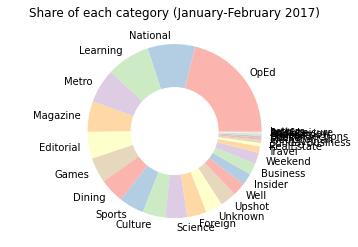

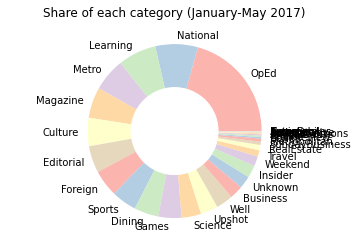

In [ ]:
# share of each category among commented articles

#January-February 2017
liste = comments.newDesk.value_counts()

plt.axis('equal')
plt.pie(comments.newDesk.value_counts(), labels=(liste.index), colors=Pastel1_7.hex_colors);
plt.title("Share of each category (January-February 2017)");

circle=plt.Circle((0,0), 0.5, color='white') # add a circle at the center to transform it in a donut chart
p=plt.gcf()
p.gca().add_artist(circle)

plt.show()

#January-May 2017
liste = comments_NN.newDesk.value_counts()

plt.axis('equal')
plt.pie(comments_NN.newDesk.value_counts(), labels=(liste.index), colors=Pastel1_7.hex_colors);
plt.title("Share of each category (January-May 2017)");

circle=plt.Circle((0,0), 0.5, color='white') # add a circle at the center to transform it in a donut chart
p=plt.gcf()
p.gca().add_artist(circle)

plt.show()

We notice that classes are not balanced, we need to: 
- delete categories with very few comments. We will keep only the 17 categories that are the most frequent. 
- we undersample 'OpEd' which is otherwise over-represented. 

In [ ]:
from sklearn.utils import resample
share = 0.3

# delete small categories and under-sample 'OpEd'
df_majority = comments[comments['newDesk'] == ('OpEd')]
df_minority = comments[comments['newDesk'].isin(["National", "Learning", "Metro", "Magazine", "Editorial", "Culture",  "Games", "Dining", "Sports",  "Science", "Foreign",  "Upshot",   "Well","Business", "Insider","Weekend"])]

n = round(df_majority.shape[0]*share)
df_majority_resampled = resample(df_majority, 
                                 replace = False, 
                                 n_samples = n, 
                                 random_state = 15) # set seed for reproductability 
data = pd.concat([df_majority_resampled, df_minority])

# the same for the bigger dataset
df_majority = comments_NN[comments_NN['newDesk'] == ('OpEd')]
df_minority = comments_NN[comments_NN['newDesk'].isin(["National", "Learning", "Metro", "Magazine", "Editorial", "Culture",  "Games", "Dining", "Sports",  "Science", "Foreign",  "Upshot",   "Well","Business", "Insider","Weekend"])]

n = round(df_majority.shape[0]*share)
df_majority_resampled = resample(df_majority, 
                                 replace = False, 
                                 n_samples = n, 
                                 random_state = 15) # set seed for reproductability 
data_NN = pd.concat([df_majority_resampled, df_minority])

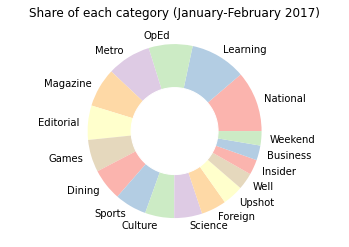

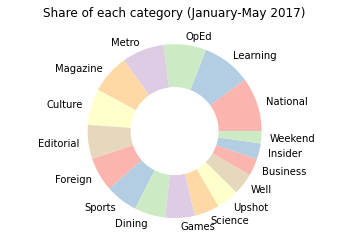

In [ ]:
# share of each category among commented articles, after the removal of small categories and undersampling of OpEd

#January-February 2017
liste = data.newDesk.value_counts()
liste.index

plt.axis('equal')
plt.pie(data.newDesk.value_counts(), labels=(liste.index), colors=Pastel1_7.hex_colors);
plt.title("Share of each category (January-February 2017)");

# add a circle at the center to transform it in a donut chart
circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

plt.show()

#January-May 2017
liste = data_NN.newDesk.value_counts()
liste.index

plt.axis('equal')
plt.pie(data_NN.newDesk.value_counts(), labels=(liste.index), colors=Pastel1_7.hex_colors);
plt.title("Share of each category (January-May 2017)");

# add a circle at the center to transform it in a donut chart
circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

plt.show()

We now have a balanced dataset that we can use. 



## 3. Exploratory analysis : WordClouds


In [ ]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

In [ ]:
data_cult   = data[data['newDesk'] == ('Culture')]
data_sports = data[data['newDesk'] == ('Sports')]
data_foreign = data[data['newDesk'] == ('Foreign')]

In [ ]:
data['commentBody']

411     How can we little people make a difference?  S...
1671    "No president, or for that matter major U.S. p...
392     The ACA should be amended to add a public opti...
1653    Regardless of whether Mr. Sessions was parsing...
1594    Bernie Sanders told the world just what was mi...
                              ...                        
1714    I skimmed this. I think the American paradox i...
1722    "A team is being assembled to focus on a varie...
1726    This column alone is going to be worth the pri...
1727    We should all remember that this man has lied ...
1728    Take a headcase dilettante buffoon of an owner...
Name: commentBody, Length: 1348, dtype: object

In [ ]:
#Set of StopWords
stopwords = set(STOPWORDS)
print(stopwords)

{'being', "she's", 'myself', 'those', 'were', 'but', 'our', 'to', 'both', 'which', 'too', "you'd", 'during', "isn't", 'by', "who's", "we've", "we'll", 'his', "they'll", 'it', 'no', 'your', "she'll", 'their', 'any', "they'd", 'this', 'again', 'as', 'have', 'and', "i'll", 'otherwise', 'about', 'do', "he'd", "aren't", 'her', "i'm", "weren't", 'who', 'with', 'other', "wouldn't", 'k', 'from', 'yourselves', "don't", 'since', 'can', "doesn't", 'yours', 'my', 'once', 'for', "we're", "couldn't", 'off', 'few', "we'd", 'why', "they're", 'com', 'was', 'she', 'they', 'however', 'there', "i'd", 'in', "haven't", "she'd", 'hers', 'its', "that's", 'shall', 'ourselves', 'if', 'itself', 'or', 'having', 'whom', 'get', 'some', 'else', 'themselves', "what's", 'also', 'doing', 'yourself', 'r', "when's", 'of', "shouldn't", 'above', 'that', 'is', 'while', 'could', 'you', 'before', "why's", "won't", "they've", "it's", "he'll", "wasn't", "where's", 'like', 'a', "shan't", 'be', "you'll", 'he', 'am', 'herself', 'w

In [ ]:
def Tokenizer(text):
    """Simple Tokenizer function which also converts complete corpus into lowercase. Input the text"""
    full_string = ''
    for sentence in text:
        sent = str(sentence)
        token = sent.split()
        for i in range(len(token)):
            token[i] = token[i].lower()
        full_string += " ".join(token)
    return full_string

In [ ]:
full_string_cult    = Tokenizer(data_cult['commentBody'])
full_string_sports  = Tokenizer(data_sports['commentBody'])
full_string_foreign  = Tokenizer(data_foreign['commentBody'])

In [ ]:
full_string_cult[0:50]

'in a prior episode (s03e05), noah says he and alli'

In [ ]:
wordcloud_cult   = WordCloud(width = 500,height=500,background_color='white',stopwords=stopwords,min_font_size=8).generate(full_string_cult)
wordcloud_sports = WordCloud(width = 500,height=500,background_color='white',stopwords=stopwords,min_font_size=8).generate(full_string_sports)
wordcloud_foreign = WordCloud(width = 500,height=500,background_color='white',stopwords=stopwords,min_font_size=8).generate(full_string_foreign)

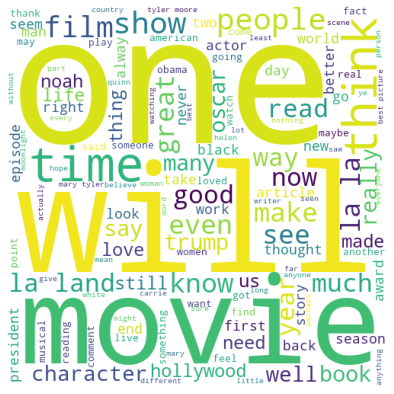

In [ ]:
#Plotting the WordCloud
plt.figure(figsize=(7,7))
plt.imshow(wordcloud_cult)
plt.axis("off")
plt.show()

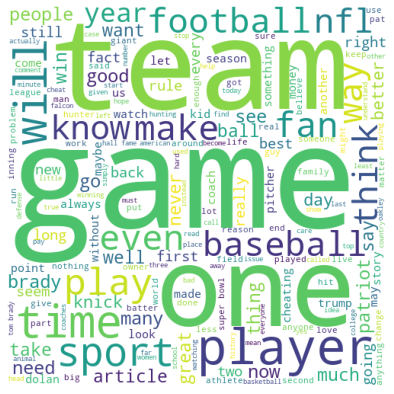

In [ ]:
#Plotting the WordCloud
plt.figure(figsize=(7,7))
plt.imshow(wordcloud_sports)
plt.axis("off")
plt.show()

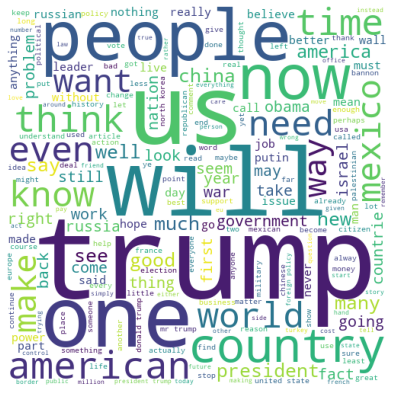

In [ ]:
#Plotting the WordCloud
plt.figure(figsize=(7,7))
plt.imshow(wordcloud_foreign)
plt.axis("off")
plt.show()

This visualisation enables to see that some newdesk present specific vocabulary while some other tends to use the same semantic fields. This may impact the performance of our models to disantangle between closely related topics. 


## 4. TF-IDF Analysis

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, classification_report, log_loss, make_scorer, 
                             recall_score, precision_recall_curve, roc_curve)

import gc
from time import time

import warnings
warnings.filterwarnings('ignore')

from nltk.stem import SnowballStemmer

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
commentBody = data.commentBody
articleID   = data.articleID
newDesk    = data.newDesk

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data.commentBody, data.newDesk, test_size=0.33, random_state=42)

In [ ]:
vectorizer = FeatureUnion([
    ('word_tfidf', TfidfVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=600,
    )),
    
    ('char_tfidf', TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 4),
    max_features=600,
    ))
])
start_vect = time()
vectorizer.fit(commentBody)
train_text = vectorizer.transform(data_train)
test_text = vectorizer.transform(data_test)

print("Vectorization Runtime: %0.2f Minutes"%((time() - start_vect)/60))

Vectorization Runtime: 20.58 Minutes


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

#### Logistic Regression 

In [ ]:
clf_logistic = Pipeline([
    ('lsa', TruncatedSVD(n_components=300, random_state=0)), 
    ('logistic', LogisticRegression(C=150))  
])     

In [ ]:
def grid_search_cv(param_grid, clf):
     gkf = GroupKFold(n_splits=3).split(train_text, train_target, groups=train_groups)
     scorer = make_scorer(recall_score)
     
     grid_search = GridSearchCV(clf, param_grid=param_grid, cv=gkf, scoring=scorer)
     grid_search.fit(train_text, train_target)
     
     print("Best parameters found:")
     print(grid_search.best_params_)
     print()
     print("Best score:")
     print(grid_search.best_score_)
     print()

In [ ]:
def train_model(clf):
    clf.fit(train_text, y_train)
    
    test_prediction = clf.predict(test_text)
    print("Classification report:")
    print(classification_report(y_test, test_prediction))

In [ ]:
start_vect = time()

test_prediction_proba_logistic = train_model(clf_logistic)

print()
print("Runtime for training logistic regression model and predicting probabilities for the test set is %0.2f Minutes"%((time() - start_vect)/60))

Classification report:
              precision    recall  f1-score   support

    Business       0.55      0.35      0.43        31
     Culture       0.66      0.70      0.68        70
      Dining       0.77      0.75      0.76        55
   Editorial       0.62      0.59      0.60        49
     Foreign       0.72      0.65      0.68        51
       Games       0.94      0.93      0.94        55
     Insider       0.24      0.16      0.19        25
    Learning       0.74      0.83      0.78        83
    Magazine       0.32      0.27      0.29        75
       Metro       0.70      0.69      0.69        74
    National       0.55      0.70      0.61        92
        OpEd       0.44      0.51      0.47        68
     Science       0.52      0.57      0.55        40
      Sports       0.77      0.85      0.81        62
      Upshot       0.39      0.31      0.34        39
     Weekend       0.33      0.12      0.17        17
        Well       0.48      0.47      0.47        30

   

In [ ]:
start_vect = time()

test_prediction_proba_logistic = train_model(clf_logistic)

print()
print("Runtime for training logistic regression model and predicting probabilities for the test set is %0.2f Minutes"%((time() - start_vect)/60))

In [ ]:
#test_prediction = train_model(clf_logistic)
clf_logistic = Pipeline([
    ('lsa', TruncatedSVD(n_components=300, random_state=0)), 
    ('logistic', LogisticRegression(C=150))  
])
clf_logistic.fit(train_text, y_train)
test_prediction = clf_logistic.predict(test_text)

In [ ]:
y_pred_labels = np.argmax(test_prediction, axis=None)


905       Dining
2461     Foreign
921        Games
958      Insider
1917    Business
          ...   
100     National
1903       Metro
713         OpEd
2192      Dining
2956     Foreign
Name: newDesk, Length: 916, dtype: object

In [ ]:
import sklearn.metrics as metrics
#y_true_labels = np.argmax(y_test, axis=None)

#y_pred = model_cnn.predict(test_text)
y_pred_labels = np.argmax(test_prediction, axis=None)
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=test_prediction)


In [ ]:
liste = y_test.value_counts()
liste.index

Index(['National', 'Learning', 'Magazine', 'Metro', 'Culture', 'OpEd',
       'Sports', 'Games', 'Dining', 'Foreign', 'Editorial', 'Science',
       'Upshot', 'Business', 'Well', 'Insider', 'Weekend'],
      dtype='object')

In [ ]:
cat = ['National', 'Learning', 'Magazine', 'Metro', 'Culture', 'OpEd',
       'Sports', 'Games', 'Dining', 'Foreign', 'Editorial', 'Science',
       'Upshot', 'Business', 'Well', 'Insider', 'Weekend']

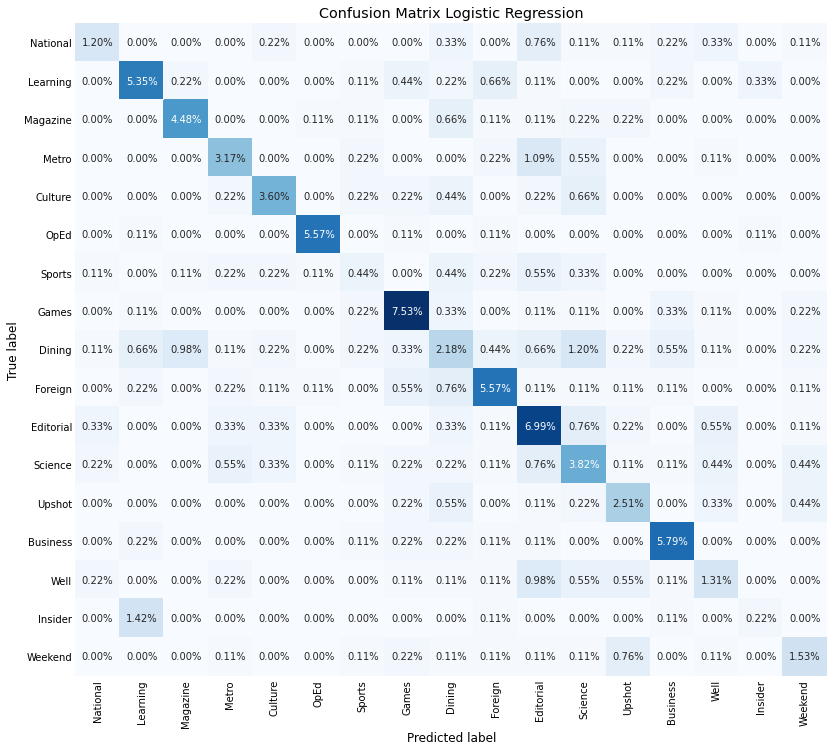

In [ ]:
make_confusion_matrix(confusion_matrix, figsize=(12,12), cbar=False, categories=cat, sum_stats=False, count=False, title='Confusion Matrix Logistic Regression')

The performances are overall quite interesting, categories are well predicted even if we spot some topics that are mistook for others. 

##### SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
steps = [('scaler', StandardScaler(with_mean=False)), ('SVM', SVC())]
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps) # define the pipeline object.

parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(train_text, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.00

In [ ]:
print(grid.best_params_)
#{'SVM__C': 10, 'SVM__gamma': 0.01}

{'SVM__C': 10, 'SVM__gamma': 0.01}


In [ ]:
clf_SVM = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('SVM', SVC(C=10, break_ties=False,
                            cache_size=200, class_weight=None,
                            coef0=0.0,
                            decision_function_shape='ovr',
                            degree=3, gamma=0.01,
                            kernel='rbf', max_iter=-1,
                            probability=False,
                            random_state=None, shrinking=True,
                            tol=0.001, verbose=False)),  
])   

In [ ]:
def train_model(clf_SVM):
    clf.fit(train_text, y_train)
    
    test_prediction = clf.predict(test_text)
    print("Classification report:")
    print(classification_report(y_test, test_prediction))

In [ ]:
start_vect = time()

test_prediction_proba_SVM = train_model(clf_SVM)

print()
print("Runtime for training SVM regression model and predicting probabilities for the test set is %0.2f Minutes"%((time() - start_vect)/60))

Classification report:
              precision    recall  f1-score   support

    Business       0.50      0.19      0.28        31
     Culture       0.66      0.63      0.64        70
      Dining       0.63      0.71      0.67        55
   Editorial       0.48      0.29      0.36        49
     Foreign       0.61      0.67      0.64        51
       Games       0.88      0.89      0.88        55
     Insider       0.00      0.00      0.00        25
    Learning       0.52      0.98      0.68        83
    Magazine       0.19      0.09      0.13        75
       Metro       0.56      0.68      0.61        74
    National       0.56      0.72      0.63        92
        OpEd       0.37      0.47      0.42        68
     Science       0.41      0.60      0.48        40
      Sports       0.80      0.71      0.75        62
      Upshot       0.53      0.26      0.34        39
     Weekend       0.00      0.00      0.00        17
        Well       0.47      0.23      0.31        30

   

In [ ]:
#test_prediction = train_model(clf_logistic
clf_SVM.fit(train_text, y_train)
test_prediction_SVM = clf_SVM.predict(test_text)

In [ ]:
y_pred_labels = np.argmax(test_prediction, axis=None)
confusion_matrix_SVM = metrics.confusion_matrix(y_true=y_test, y_pred=test_prediction_SVM)
liste = y_test.value_counts()
liste.index

Index(['National', 'Learning', 'Magazine', 'Metro', 'Culture', 'OpEd',
       'Sports', 'Games', 'Dining', 'Foreign', 'Editorial', 'Science',
       'Upshot', 'Business', 'Well', 'Insider', 'Weekend'],
      dtype='object')

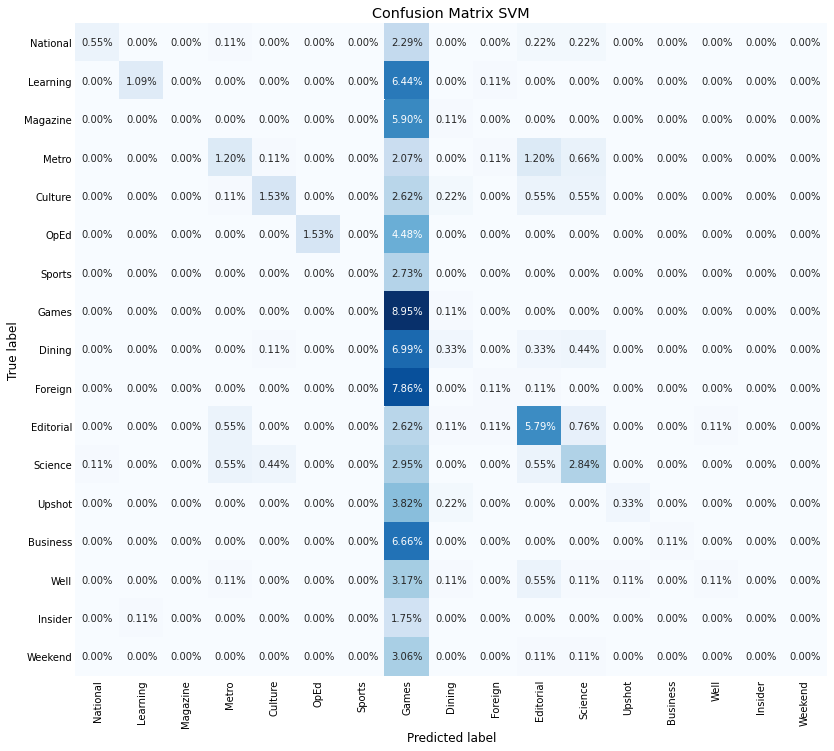

In [ ]:
make_confusion_matrix(confusion_matrix_SVM, figsize=(12,12), cbar=False, categories=cat, sum_stats=False, count=False, title='Confusion Matrix SVM')

voir si on ne le retire pas 

#### Lemmatizer ?

In [ ]:
# On ajoute un lemmatiser 

In [ ]:
stemmer = SnowballStemmer('english', ignore_stopwords=False)

class StemmedTfidfVectorizer(TfidfVectorizer):
    
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedTfidfVectorizer, self).__init__(*args, **kwargs)
        self.stemmer = stemmer
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (self.stemmer.stem(word) for word in analyzer(doc.replace('\n', ' ')))

vectorizer_stem_u = StemmedTfidfVectorizer(stemmer=stemmer, sublinear_tf=True)
X_train_stem = vectorizer_stem_u.fit_transform(data_train)
X_train_stem.shape

X_test_stem = vectorizer_stem_u.fit_transform(data_test)


In [ ]:
def train_model(clf):
    clf.fit(X_train_stem, y_train)
    
    test_prediction = clf.predict(X_test_stem)
    print("Classification report:")
    print(classification_report(y_test, test_prediction))

#### Evaluation 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

random_state = np.random.RandomState(0)
n_samples, n_features = train_text.shape

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(train_text, y_train).decision_function(test_text)

In [ ]:
y_score

array([[-1.13336836, -1.30219369, -0.57289525, ..., -1.05374732,
        -0.99121229, -1.19848447],
       [-1.03372133, -1.23182718, -1.37463023, ..., -1.11666033,
        -1.07522781, -1.09997598],
       [-1.04616068, -0.89075855, -1.42830342, ..., -1.03686314,
        -1.03220724, -1.13187615],
       ...,
       [-1.05021171, -1.1114594 , -1.2292104 , ..., -1.07581431,
        -1.04652257, -1.18364119],
       [-1.05596607, -1.39973454, -0.37395681, ..., -1.05672263,
        -1.24881832, -1.15486485],
       [-1.03026451, -1.18101783, -1.29445892, ..., -1.06311528,
        -1.07073799, -1.1328307 ]])

In [ ]:
liste = data.newDesk.value_counts()
liste.index

Index(['National', 'Learning', 'OpEd', 'Metro', 'Magazine', 'Culture',
       'Editorial', 'Sports', 'Dining', 'Games', 'Foreign', 'Science',
       'Upshot', 'Well', 'Business', 'Insider', 'Weekend'],
      dtype='object')

In [ ]:
y = label_binarize(y_train, liste.index)
ytest = label_binarize(y_test, liste.index)

n_classes = y.shape[1]
n_classes

17

In [ ]:
y_score.shape

(916, 17)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest[i], y_score[i,:])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

In [ ]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ytest.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

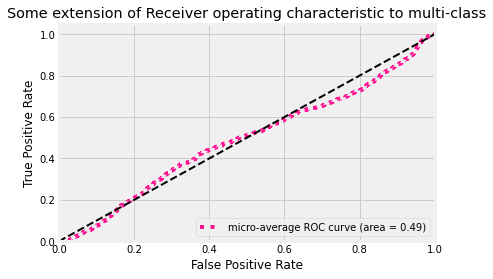

In [ ]:
# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

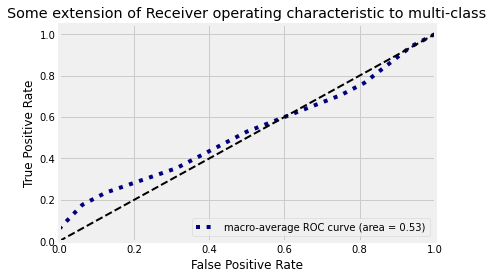

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We use micro and macro average ROC curve. The macro-average computes the metric independently for each class and then take the average (hence treating all classes equally), whereas the micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable when there is class imbalance. 

The two AUC are similar which is reassuring as we pay attention to class balancing. The AUC is around 0.5, which is not an outstanding perfomance (as it corresponds to the SVC modem that was already performing quite badly. 





## 5. Neural network Analysis : Gloves and LSTM 

We will use a Long Short Term Memory (LSTM) model. As part of Recurrent Neural Networks, LSTM models may work well on sequential data, here on our compilations of comments. Essentially LSTMs have shown a better performance working with long texts than most of the other Recurrent Neural Networks, which can be very helpful here : indeed, some comments (and a fortiori compilations of comments) are quite long.

Let us notice that we implement a word embeddings based model. To that end, we use "glove". Each compilation of comments is tokenized, then each token is transformed into its index-based representation, then, each index-based representation is passed sequentially through an embedding layer based on glove vectors. This embedding layer will output an embedded representation of each token whose are passed through a LSTM neural net, then the last LSTM’s hidden state is be passed through a linear layer neural net.

The philosophy of the model and the code below are heavily based on the work by Aakanksha NS "Multiclass Text Classification using LSTM in Pytorch : predicting item ratings based on customer reviews" (https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df). In particular, the incusion of a the glove embedding and the general architecture of the model followed Aakanksha NS's project. However, in Aakankha NS's project about reviews and ratings, classes could be ordered ("Awesome" > "Good" > "Meh" > "Yuck") which was not the case for our projet ("National", "Foreign, "Editorial", "Games", ... cannot be ordered). Thus, we had to adapt validation metrics. To a lesser extent, work by Fernando López provided also some help (https://towardsdatascience.com/text-classification-with-pytorch-7111dae111a6).

Note: compared to others methods, here we will use a larger dataset. It makes the process slower but it improves the results by a lot (otherwise, the training set is too small and there is overlearning).

In [ ]:
#library imports
import torch
import torch.nn   as nn
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from nltk.tokenize import TreebankWordTokenizer
import pdb

In [ ]:
#tokenization

def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return TreebankWordTokenizer().tokenize(nopunct)

In [ ]:
#count number of occurences of each word...
counts = Counter()
for index, row in data_NN.iterrows():
    counts.update(tokenize(row['commentBody']))

#delete infrequent words
#we will consider the words in the corpus that are at least repeated twice.
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

#load the glove word vectors
glove_word_vecs = {}
with open("glove.6B/glove.6B.50d.txt") as f:
  for line in f:
    split = line.split()
    glove_word_vecs[split[0]] = np.array([float(x) for x in split[1:]])   

#create vocabulary
#create the embedding matrix from word vectors
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    
    vocab_size = len(word_counts) + 2
    vocab = ["", "UNK"]
    vocab_to_idx = {}
    W = np.zeros((vocab_size, emb_size), dtype="float32")

    vocab_to_idx["UNK"] = 1
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 

    i = 2
    for word in word_counts:
      vocab.append(word)
      vocab_to_idx[word] = i
      if word in pretrained:
          W[i] = pretrained[word]
      else:
          W[i] = np.random.uniform(-0.25,0.25, emb_size)
      i += 1 

    return np.array(vocab), vocab_size, vocab_to_idx,  W

vocab, vocab_size, vocab2index,  pretrained_weights = get_emb_matrix(glove_word_vecs, counts, 50)

num_words before: 240134
num_words after: 103692


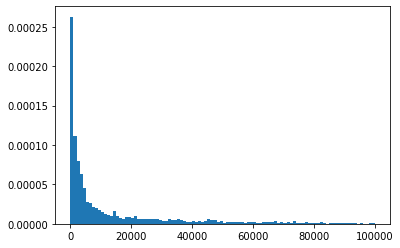

In [ ]:
#for information: compute number of tokens per compilation of comments
data_NN['number_tokens'] = data_NN['commentBody'].apply(lambda x: len(tokenize(x)))
plt.hist(data_NN["number_tokens"], bins = 100, range=(0,100000), density =True)
plt.show()

In [ ]:
#encode
#about 25% of compilations of comments have less than 1000 words
#we restrict the length of a given compilation of comments to 1000 words
#we tried a bigger size of the matrix (5000 because more than than 50% of compilations of comments have less than 5000 words)...
#... but it slowed down the training too much.

def encode_sentence(text, vocab2index, N): #N restrict the size of the sentence.
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

data_NN['encoded'] = data_NN['commentBody'].apply(lambda x: np.array(encode_sentence(x,vocab2index, 1000)))
data_NN.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


,articleID,newDesk,commentBody,number_tokens,encoded
4143,59208b4a7c459f24986e0be7,OpEd,What you have to remember. The present does no...,6957,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 4, 11, 12, 13, 1..."
3804,59128a1b7c459f24986dea48,OpEd,"Once again, the news is real. It's the Presid...",98435,"[[1179, 751, 7, 170, 38, 342, 84, 125, 7, 248,..."
3710,590e16957c459f24986de1b8,OpEd,I count approximately 57 white men and 5 whit...,54896,"[[140, 3272, 9087, 156, 2148, 54, 156, 2149, 2..."
2107,58c8eb7b7c459f247805bdef,OpEd,All of the Trumps are hucksters. Democrats in...,63165,"[[283, 32, 7, 2338, 340, 2075, 748, 7038, 672,..."
4044,591c8ba17c459f24986e0220,OpEd,I appreciate you correctly rephrasing your ess...,2357,"[[140, 4654, 3, 4436, 14064, 64, 8382, 16, 263..."


In [ ]:
#change newDesk categories to numbers
new_Desk_numbering = {}
cat = list(set(data["newDesk"]))
for i in range(len(cat)):
  new_Desk_numbering[cat[i]] = i
data_NN['newDesk_number'] = data_NN['newDesk'].apply(lambda x: new_Desk_numbering[x])

In [ ]:
#split train-test
X = list(data_NN['encoded'])
y = list(data_NN['newDesk_number'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In order to get ready the training phase, first, we need to prepare the way how the sets of comments will be fed to the model. The aim of RevewsDataset class and DataLoader (a class furnished by pytorch) is to provide an easy way to iterate over a dataset by batches. 

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
batch_size = 25
train_dl = DataLoader(ReviewsDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(ReviewsDataset(X_test, y_test), batch_size=batch_size)

For the training phase, we will use a cross-entropy loss, which suits multi-class text classification.


In [ ]:
def train_model(model, epochs=10, lr=0.05):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        test_loss, test_acc = validation_metrics(model, test_dl)
        print("train loss %.3f, test loss %.3f, test accuracy %.3f" % (sum_loss/total, test_loss, test_acc))

def validation_metrics (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in test_dl:
        x = x.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

We propose a very simple LSTM architecture.

- As input layer, it is implemented an embedding layer. This embedding layer takes each token and transforms it into an embedded representation thanks to the help of glove. The version of glove we use has a dimension of 50, thus, the embedding size must be 50 as well. 
- Such an embedded representations is then passed through a LSTM layer. We impose the dimension of the output of LSTM has a dimension of 150 (we tried 10, 50, 100, 150 and 200 ; 10 and 50 showed worst results that 100 but 150, 200, while requiring much more time to run, did not improve the results with regards to accuracy in the test sample). 
- Finally, the LSTM is passed through a linear layer neural net. The size of the output from the linear layer must be of the size of the number of types of articles. We tried a 2-layers linear neural net but it did not improve test accuracy.

In [ ]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(set(data['newDesk'])))           
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model = LSTM_glove_vecs(vocab_size, 50, 100, pretrained_weights)
train_model(model, epochs=30, lr=0.01) #batch size=25

train loss 2.653, test loss 2.631, test accuracy 0.159
train loss 2.538, test loss 2.518, test accuracy 0.155
train loss 2.434, test loss 2.515, test accuracy 0.165
train loss 2.494, test loss 2.760, test accuracy 0.141
train loss 2.371, test loss 2.385, test accuracy 0.211
train loss 2.182, test loss 2.324, test accuracy 0.222
train loss 2.110, test loss 2.297, test accuracy 0.246
train loss 1.983, test loss 2.146, test accuracy 0.290
train loss 1.770, test loss 1.996, test accuracy 0.331
train loss 1.693, test loss 1.953, test accuracy 0.339
train loss 1.536, test loss 1.949, test accuracy 0.371
train loss 1.441, test loss 1.862, test accuracy 0.408
train loss 1.359, test loss 2.150, test accuracy 0.344
train loss 1.357, test loss 1.968, test accuracy 0.388
train loss 1.267, test loss 1.936, test accuracy 0.395
train loss 1.178, test loss 1.895, test accuracy 0.432
train loss 1.074, test loss 1.906, test accuracy 0.426
train loss 1.053, test loss 1.977, test accuracy 0.417
train loss

In [ ]:
def prepare_matrix_confusion_y_test_pred (model, test_dl):
  model.eval()
  test_prediction = []
  for x, y, l in test_dl:
      y_hat = model(x, l)
      pred = torch.max(y_hat, 1)[1]
      test_prediction += list(pred.numpy())
  confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=test_prediction)
    
  return confusion_matrix, [cat[int(i)] for i in test_prediction]

confusion_matrix, y_test_pred = prepare_matrix_confusion_y_test_pred (model, test_dl)

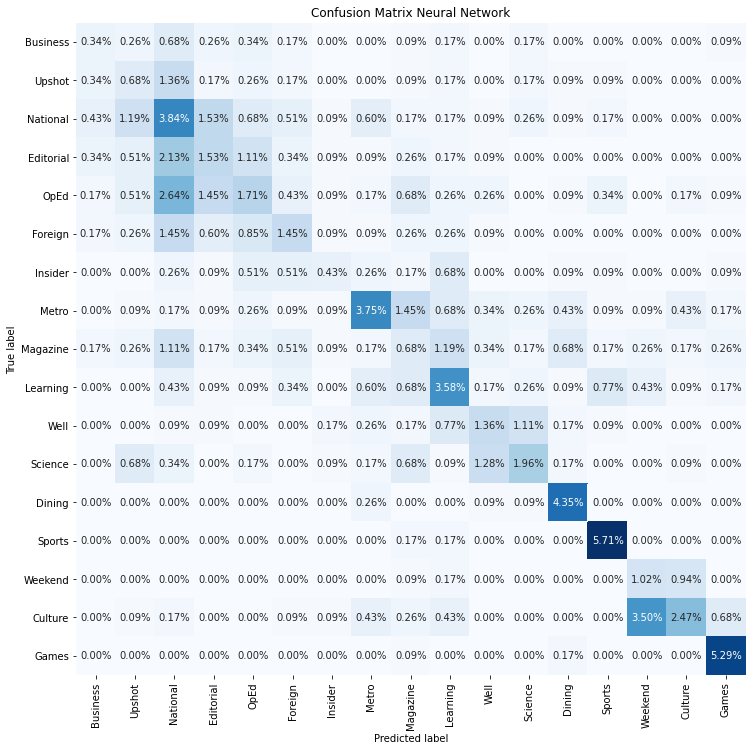

In [ ]:
original_order = {}
for i in range(len(cat)): original_order[cat[i]] = i  

cat_reordered = ['Business','Upshot','National','Editorial','OpEd','Foreign',
                 'Insider','Metro','Magazine','Learning','Well','Science',
                 'Dining','Sports','Weekend','Culture','Games']

tool_to_reorder = [original_order.get(topic) for topic in cat_reordered]

reordered_confusion_matrix = np.asarray([[confusion_matrix[i,j] for j in tool_to_reorder] for i in tool_to_reorder])

make_confusion_matrix(reordered_confusion_matrix, figsize=(12,12), 
                      cbar=False, categories=cat_reordered, 
                      sum_stats=False, count=False, 
                      title='Confusion Matrix Neural Network')

From the previous confusion matrix, we make a number of remarks:
- The neural network is quite good when it comes to distinguish Politics/Opinion topics from Leisure topics,
- Within Politics/Opinion topics, the neural network finds it quite difficult to predict the right topic of the article based on the compilation of its comments,
- Within Leisure topics, the neural network is quite good at predicting the right topic.

We will pick a small sample of misclassified compilations of articles and try to understand why they have been misclassified

In [ ]:
data_NN['encoded_string']= data_NN['encoded'].apply(lambda x : str(x))

df_qualitative = pd.DataFrame(list(zip(X_test, y_test_pred)), columns=["encoded", "newDesk_pred"])
df_qualitative['encoded_string'] = df_qualitative['encoded'].apply(lambda x : str(x))

df_qualitative = pd.merge(df_qualitative, data_NN[['encoded_string','newDesk','commentBody']], on="encoded_string")

df_qualitative = df_qualitative[["newDesk_pred", "newDesk", "commentBody"]]

In [ ]:
#Compilation of comments attached to a National article that was misclassified as Foreign.
df_qualitative[(df_qualitative["newDesk"]=="National") & (df_qualitative["newDesk_pred"]=="Foreign")]["commentBody"].iloc[0]
#The military, Defense, terrorists, China... are mentionned in the comments. It may explain the missclassification.

'Take food out of children\'s mouths, cut off heat for the poor, throw millions off of medical assistance, fire thousands of federal employees, steal GI benefits, kill off PBS? All this for a silly wall that will accomplish nothing and to toss more money at the military, which is as large as the next ten largest militaries combined. I\'ve never seen such a disgusting human being take the reins of office.This entire budget favors the military. It is the president\'s attempt to prove himself to his base and his "generals". To make up for dodging the draft all those years ago. So what if Americans in need suffer from this egotistical need to play General. We all know guns make up for lacking in other places. Too bad that a lot of his supporters will be in the direct line of fire. It will be up to compassionate Americans to make up the difference and trump won\'t be one of them. He won\'t care.50 years ago we had channels 2, 4, 5, 7, 9 and 11.  13 was PBS.  Now we have 600 channels.   Publ

In [ ]:
#Compilation of comments attached to a WeekEnd article that was misclassified as Culture.
df_qualitative[(df_qualitative["newDesk"]=="Weekend") & (df_qualitative["newDesk_pred"]=="Culture")]["commentBody"].iloc[0]
#The article seems to have been a review of a movie : misclassifying it as a Culture article does make sense.

'I enjoyed this film, largely due to the fantastic sets and photography and the European setting (gets real boring watching films set in the US). The similarities to Shutter Island was a little too marked for my taste. I kept thinking I was watching Leo di Caprio with weird contacts. I was also puzzled because I sat the whole way waiting for the appearance of one of my favourite actors. Oscar Isaac, only to realise he wasn\'t in it - It was Jason Isaacs! Hate it when that happens... other than that it was pleasantly whacko outing but really a tad overlong.I believe you completely missed the point. This is a movie about ego destruction, just like Fight Club and The Matrix.I was totally engrossed in this movie. One of my best for the year so far. This movie is almost a straight book-to-movie translation of The Magic Mountain by Thomas Mann, arguably my favorite book -- with a few horror elements thrown in.Eels. After watching "the Tin Drum" eons ago, I will never ever ever ever ever ever

In [ ]:
#Compilation of comments attached to a OpEd article that was misclassified as Sports.
df_qualitative[(df_qualitative["newDesk"]=="OpEd") & (df_qualitative["newDesk_pred"]=="Sports")]["commentBody"].iloc[1]
#It appears that baseball, field, play are mentionned several times, which might explain that the comment was misclassified as Sports.

'I loved this column and always look forward to Doug Glanville\'s pieces.  As I read what he had to say about Tim Raines whom I\'m delighted to see voted in I wondered what his thoughts might be about Brett Butler.  Butler was a consistent 400 percentage on base ball player.  He was a master bunter and base stealer and had a long career as a top of the order catalyst for the Braves, Indians and Dodgers.  He\'s the type of player who would never have gotten a look previously because he had no power and only an average arm for an outfielder but in this era might well be worth a second look.What comes through to me by Glanville\'s excellent article is that the baseball players themselves always know who is the best player. They know from the field of play. This knowledge, this understanding, based on actual experience, should be, should have been, incorporated into the HOF protocols a long time ago. Sports writers have at best a distant view of actual performance and are not the best judg

In [ ]:
#Compilation of comments attached to a Magazine article that was misclassified as National.
df_qualitative[(df_qualitative["newDesk"]=="Magazine") & (df_qualitative["newDesk_pred"]=="National")]["commentBody"].iloc[0]
#From the comments, it really seems that the article was about national politics, which a topic currently associated with "National" class.

'They huffed and they puffed...and they huffed and they puffed...and they, well you get the idea. Trump got all of his cabinet nominees approved; he will apparently get his Supreme Court nominee approved; his and his staff continue to dismantle Obama\'s legacy; and the Democrats will continue to huff and puff.What a tired old bunch they are. Nancy Pelosi is 76; her assistants are 77 and 76. Chuck Schemer is 66. Elizabeth Warren is 67 and Bernie Sanders is 75. Where are the young spokesmen for the party. Is it realistic to expect any of these traditional politicians to figure out how to be the Tea Party of the Left. Tea Partymembers are not steeped in the traditions of government nor do they hold the idea of government in high regard. They were and are effective because they started as outsiders. Does anybody consider any of the current Democrat leaders outsiders. Hardly the group to start a revolution.So, let the huffing and puffing continue. Meanwhile, the regulations will disappear, 

In [ ]:
#Compilation of comments attached to a Magazine article that was misclassified as Dining.
df_qualitative[(df_qualitative["newDesk"]=="Magazine") & (df_qualitative["newDesk_pred"]=="Dining")]["commentBody"].iloc[0]
#Comments are a lot about food (egg, cheese, eating...). Once again, the missclassification could habe been made by a human.

'This makes me laugh - I\'m from New Orleans where we\'ve been eating a version of this my entire life - didn\'t know we were eating something so famous! In fact, I made it for breakfast yesterday. Can\'t wait to tell my parents and my brothers!Can\'t wait to make this. What kind of mustard is typically used? I believe the name has history. Mr. Kejriwal hailed from a traditional marwari family where egg is considered non-vegetarian. But Mr. Kejriwal loved his eggs and what began as his special made-to-order secret \'banned\' meal at the Wellington is now a part of history.  To get melted cheese over egg: when you flip the egg over to lightly cook the other side, put your shredded cheese on top. It will melt. You can cover the pan for half a minute if you want. That\'s it. You will have a perfect egg (white cooked, yolk runny) with melted cheese. Very well presented.Tejal, can you please do a write-up on omelettes done the Indian way?I live in Mumbai.   And I confess I had never heard o

## 6. Word2VEC and LDA analysis




In this section, we explore another embedding, namely word2vec and explore whether this approach would perform better combined with LDA. 

We start with some classic preprocessing: tokenizing, remowing meaningless words, steeming and eventually vectorizing words. (For word2vec, steeming and vectorizing are already included). The idea is mainly to see whether this embedding method is better performing than the logistic regression + TFIDF.




1. Preprocessing

In [ ]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  

In [ ]:
data

,articleID,articleWordCount,newDesk,sectionName,commentBody,numberComments
411,587e4a3d95d0e0392607b28d,1790,OpEd,Unknown,How can we little people make a difference? S...,155
1671,58b9278a95d0e024902fd4c1,819,OpEd,Unknown,"""No president, or for that matter major U.S. p...",546
392,587dd40a95d0e0392607b0ff,941,OpEd,Unknown,The ACA should be amended to add a public opti...,880
1653,58b846e995d0e024902fd298,888,OpEd,Unknown,Regardless of whether Mr. Sessions was parsing...,863
1594,58b63a6895d0e024902fcc93,33,OpEd,Unknown,Bernie Sanders told the world just what was mi...,191
...,...,...,...,...,...,...
1714,58bb15c095d0e024902fd8cf,912,Editorial,Sunday Review,I skimmed this. I think the American paradox i...,306
1722,58bb325795d0e024902fd8fe,1175,Editorial,Unknown,"""A team is being assembled to focus on a varie...",110
1726,58daa37895d0e02489b93cf9,981,Culture,Television,This column alone is going to be worth the pri...,12
1727,58daa3f695d0e02489b93d21,1318,National,Politics,We should all remember that this man has lied ...,1022


In [ ]:
df = data

In [ ]:
commentBody = data.commentBody
articleID   = data.articleID
newDesk    = data.newDesk
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [ ]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
our_special_word = 'qwerty'

In [ ]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['commentBody'] = df.commentBody.str.lower()
    df['document_sentences'] = df.commentBody.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
def lda_get_good_tokens(df):
    df['commentBody'] = df.commentBody.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.commentBody))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(df_train)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
dictionary = Dictionary(documents=df_train.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 232672 words.


In [ ]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 39569 words.


In [ ]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2. LDA

In [ ]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

In [ ]:
corpus = df_train.bow

In [ ]:
%%time
num_topics = 17
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 2min 40s, sys: 1min 27s, total: 4min 7s
Wall time: 2min 46s


In [ ]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

df_train['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      df_train.bow))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
liste = df_train['sectionName'].value_counts()
liste.index

Index(['Unknown', 'Politics', 'Asia Pacific', 'Family', 'Television', 'Live',
       'Sunday Review', 'Pro Football', 'Lesson Plans', 'Move', 'Soccer',
       'Mind', 'Eat', 'Europe', 'Baseball', 'Pro Basketball', 'DealBook',
       'Americas', 'Middle East', 'College Basketball', 'Tennis', 'Media',
       'Music', 'Golf', 'Economy', 'Hockey', 'Canada', 'Africa',
       'College Football', '401(k)'s and Similar Plans'],
      dtype='object')

In [ ]:
#df_train

In [ ]:
Unkn_topic_distribution                = df_train.loc[df_train.sectionName == 'Unknown', 'lda_features'].mean()
SundayReview_topic_distribution        = df_train.loc[df_train.sectionName == 'Sunday Review', 'lda_features'].mean()
TV_topic_distribution                  = df_train.loc[df_train.sectionName == 'Television', 'lda_features'].mean()


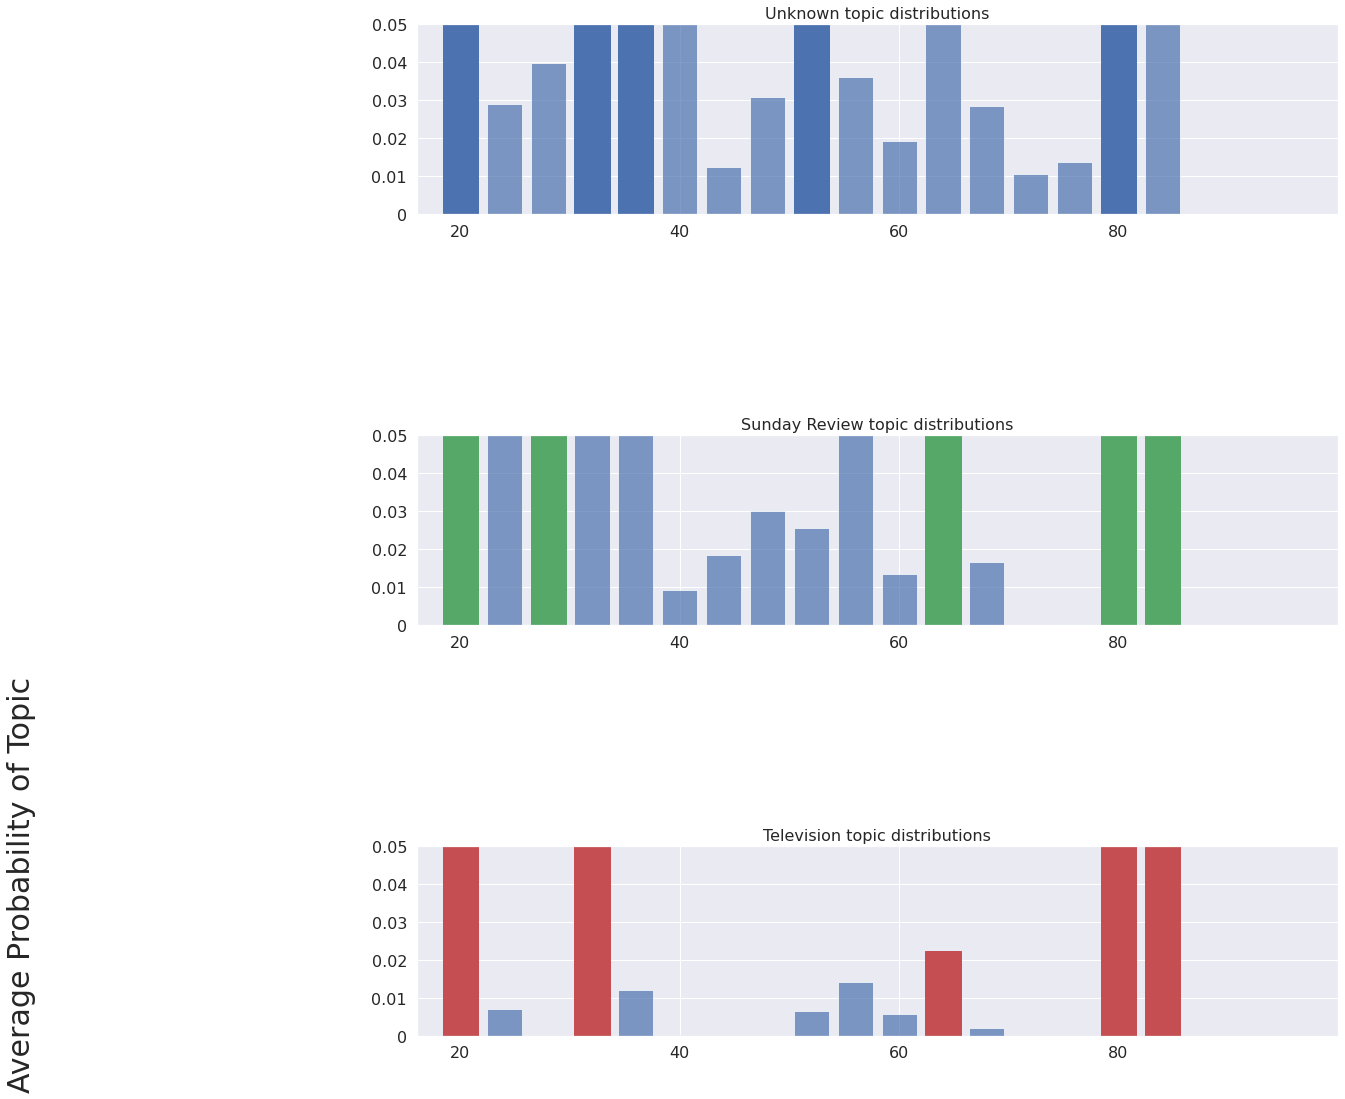

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))

nr_top_bars = 5

ax1.set_title("Unknown topic distributions", fontsize=16)
ax2.set_title("Sunday Review topic distributions", fontsize=16)
ax3.set_title("Television topic distributions", fontsize=16)
ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [Unkn_topic_distribution, SundayReview_topic_distribution, TV_topic_distribution],
                                   ['b','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 20)
    ax.set_xticks(range(0,20,5))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.05)
    ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
    ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05], fontsize=16)

fig.tight_layout(h_pad=3.)

In [ ]:
df_train.newDesk

828        Metro
1608    National
1124      Upshot
1164    Learning
786     Learning
          ...   
1366     Insider
1415    Learning
1650    Learning
1044       Games
1410     Foreign
Name: newDesk, Length: 903, dtype: object

Word2vec

In [ ]:
sentences = []
for sentence_group in df_train.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(df_train)))

Number of sentences: 910588.
Number of texts: 903.


In [ ]:
%%time
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 19min 48s, sys: 3.26 s, total: 19min 51s
Wall time: 10min 18s


In [ ]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

df_train['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      df_train.tokenized_sentences))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(df_train.newDesk)
df_train['newsDesk'] = label_encoder.transform(df_train.newDesk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


3. Model selection

We explore the performances on each treated dataset using our best performing model, *i.e* a logistic regression. 
We also compare the performance of a mixed approach that cobines LDA ans Word2vec. 

In [ ]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    #show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    #for col in result_df.columns:
    #    if col.startswith('param_'):
    #        show_columns.append(col)
    #display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [ ]:
X_train_lda = np.array(list(map(np.array, df_train.lda_features)))
X_train_w2v = np.array(list(map(np.array, df_train.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [ ]:
# store all models in a dictionary
models = dict()

In [ ]:
# Word2Vec features only
lr = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, df_train.newDesk)

models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


In [ ]:
print(best_lr_w2v)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=True)


In [ ]:
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, df_train.newDesk)

models['best_lr_lda'] = best_lr_lda
print(best_lr_lda)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=True)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [ ]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, df_train.newsDesk)

models['best_lr_combined'] = best_lr_combined
print(best_lr_combined)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=True)


In [ ]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_w2v has a test score of: -2.2117
Model best_lr_lda has a test score of: -2.0142
Model best_lr_combined has a test score of: -1.8498


In [ ]:
print(df_test.shape)
df_test.head(3)

(445, 6)


,articleID,articleWordCount,newDesk,sectionName,commentBody,numberComments
233,58759fc695d0e0392607a07e,678,Games,Unknown,"Yes, ""skein"" as a ball of yarn made me heave a...",79
974,58997e9a95d0e0392607ef82,1819,Foreign,Europe,"Unfortunately, the Bannon type of extreme righ...",932
971,5899384695d0e0392607ef18,644,Games,Unknown,"Fun puzzle, but ""Queen's Place"" is a repeat th...",42


In [ ]:
lda_preprocessing(df_test)
w2v_preprocessing(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
df_test['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     df_test.bow))
df_test['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     df_test.tokenized_sentences))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [ ]:
df_test['newDesk'] = label_encoder.transform(df_test.newDesk)

ValueError: ignored

In [ ]:
X_test_lda = np.array(list(map(np.array, df_test.lda_features)))
X_test_w2v = np.array(list(map(np.array, df_test.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

In [ ]:
submission_predictions = best_lr_combined.predict_proba(X_test_combined)

In [ ]:
label_encoder.classes_  # exactly the order in which we need to submit the writers 

array(['Business', 'Culture', 'Dining', 'Editorial', 'Foreign', 'Games',
       'Insider', 'Learning', 'Magazine', 'Metro', 'National', 'OpEd',
       'Science', 'Sports', 'Upshot', 'Weekend', 'Well'], dtype=object)

In [ ]:
result = np.append(df_test.articleID.values.reshape(-1,1), submission_predictions, axis=1)

In [ ]:
submission_df = pd.DataFrame(data=result, columns=['ID', 'Business', 'Culture', 'Dining', 'Editorial', 'Foreign', 'Games',
       'Insider', 'Learning', 'Magazine', 'Metro', 'National', 'OpEd',
       'Science', 'Sports', 'Upshot', 'Weekend', 'Well'])

In [ ]:
submission_df

,ID,Business,Culture,Dining,Editorial,Foreign,Games,Insider,Learning,Magazine,Metro,National,OpEd,Science,Sports,Upshot,Weekend,Well
0,58759fc695d0e0392607a07e,0.00826782,0.15676,0.0140347,0.0124109,0.00796991,0.278024,0.026516,0.103687,0.064091,0.101308,0.00947727,0.0229765,0.00842919,0.092018,0.00650021,0.0671098,0.020419
1,58997e9a95d0e0392607ef82,0.0121042,0.0192866,0.0135372,0.11805,0.273326,0.00195045,0.0199381,0.0652263,0.0923203,0.0420258,0.113831,0.179548,0.00850603,0.00915632,0.0157898,0.00591488,0.00948953
2,5899384695d0e0392607ef18,0.00702922,0.152479,0.0115621,0.0093858,0.00649471,0.342403,0.022449,0.0841337,0.0470314,0.0977963,0.0069662,0.0173457,0.00470763,0.0987515,0.00445732,0.0728426,0.0141641
3,58999c8495d0e0392607efda,0.0417827,0.043779,0.028752,0.0485526,0.130191,0.0153514,0.0470357,0.0909051,0.131709,0.153135,0.0449708,0.108427,0.0144527,0.0323203,0.0320062,0.0210713,0.0155586
4,58a8536595d0e0247463753c,0.00445658,0.119619,0.00809091,0.00595488,0.0036656,0.494578,0.0160693,0.0723403,0.0304178,0.0662977,0.00402543,0.010354,0.00363674,0.087575,0.00291933,0.0586848,0.0113145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,5886dfaa95d0e0392607c626,0.0119827,0.0271781,0.0116221,0.0207005,0.0181925,0.00936972,0.0230568,0.168398,0.141532,0.0919578,0.0414666,0.0468262,0.191695,0.023475,0.0383846,0.00714547,0.127017
441,58b6393a95d0e024902fcc8c,0.00796403,0.262244,0.0136504,0.0165239,0.0100701,0.118639,0.0247904,0.0988826,0.0789468,0.0660649,0.011769,0.0334838,0.00899489,0.127181,0.00724241,0.0907151,0.0228382
442,58924a9195d0e0392607e0fa,0.0593638,0.0121606,0.0125868,0.0953457,0.0779261,0.0019019,0.0291788,0.107207,0.0752251,0.0600834,0.191107,0.155778,0.0190258,0.014021,0.0703175,0.00471856,0.0140524
443,58a191b995d0e024746361a4,0.00819951,0.00686359,0.0127222,0.0156871,0.0132941,0.00127944,0.0122893,0.0914886,0.11152,0.0265877,0.0358941,0.0330922,0.467941,0.0058033,0.0457573,0.0016663,0.109915


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
y_pred_labels = np.argmax(submission_predictions, axis=1)
y_test = df_test['newDesk']
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)
liste = y_test.value_counts()
liste.index

Int64Index([10, 9, 7, 13, 5, 11, 3, 8, 2, 1, 14, 12, 4, 16, 15, 6, 0], dtype='int64')

In [ ]:
cat = ['National', 'Learning', 'Magazine', 'Metro', 'Culture', 'OpEd',
       'Sports', 'Games', 'Dining', 'Foreign', 'Editorial', 'Science',
       'Upshot', 'Business', 'Well', 'Insider', 'Weekend']

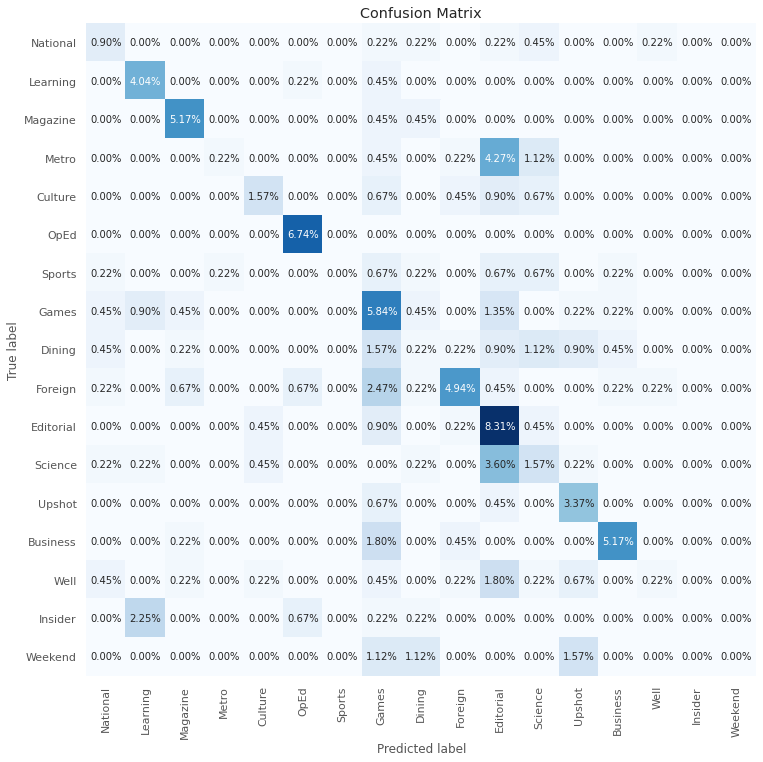

In [ ]:
make_confusion_matrix(confusion_matrix, group_names=None, figsize=(12,12), cbar=False, categories=cat, sum_stats=False, count=False, title='Confusion Matrix')

We find that the best performong version is the one that combines LDA and Word2vec. 

The confusion matrix here again shows that topics which are close are more often mispredicted for other related or close ones.
Overall, leisure categories are well distinguished from politic/buisness topics but are misclassified by ``sub-topic''.

The performance are not better than with a TF-IDF approach. This could be due to the fact that reweighting the most frequent words to give them less importance allows to capture the rare words that might be more topic specific and therefore more relevant for topic classifiction. 

## 10. Brouillon

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# connexion du drive pour accéder au fichier (sinon il faut le remettre à chaque fois)

In [ ]:
! cp '/content/drive/MyDrive/Projet_NLP/kaggle.json' ~/.kaggle/
# copie kaggle.json dans le dossier kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
# donne les droits à kaggle.json

In [ ]:
! kaggle datasets list 
# vérifie que tou fonctionnne et qu'on accède au db kaggle 

In [ ]:
! kaggle datasets download -d aashita/nyt-comments
# télécharge les données kaggles 
# NB il faut ensuite les copier dans un drive 

In [ ]:
! unzip /content/drive/MyDrive/Projet_NLP/nyt-comments.zip -d nyt_data
# unzippe vers un dossier nyt_data (qu'il vaut mieux ensuite copier sur le drive pour ne pas tout recommencer)